In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import qmc
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

In [2]:
def quantify_null_density_area(kde, num_features, threshold=1e-5, num_samples=10000):
    """
    Quantify the proportion of feature space [0, 1]^p with density below a threshold
    using Latin Hypercube Sampling.
    
    Parameters:
    kde : sklearn.neighbors.KernelDensity object
        The trained KDE object
    num_features : int
        The number of features (dimensionality of the space)
    threshold : float, optional
        The density threshold below which is considered "null" (default 1e-5)
    num_samples : int, optional
        The number of points to sample using LHS (default 10000)
    
    Returns:
    float
        The proportion of the feature space with density below the threshold
    """
    # Create Latin Hypercube sampler
    sampler = qmc.LatinHypercube(d=num_features)
    
    # Generate samples in [0, 1]^p space
    lhs_samples = sampler.random(n=num_samples)
    
    # Evaluate the KDE at each sample point
    log_densities = kde.score_samples(lhs_samples)
    densities = np.exp(log_densities)
    
    # Calculate the proportion of low-density areas
    # n_null_density_samples / n_samples
    null_density_ratio = np.mean(densities < threshold)
    
    return null_density_ratio

In [3]:
def scott_bandwidth(data):
    data = np.atleast_2d(data.T).T
    n, d = data.shape
    mean = np.mean(data, axis=0)
    euclidean_distances = np.sqrt(np.sum((data - mean)**2, axis=1))
    std = np.std(euclidean_distances)
    return n**(-1./(d+4)) * std

def silverman_bandwidth(data):
    """
    Compute Silverman's rule for bandwidth selection.
    """
    data = np.atleast_2d(data.T).T
    n, d = data.shape
    
    # Calculate mean and Euclidean distances
    mean = np.mean(data, axis=0)
    euclidean_distances = np.sqrt(np.sum((data - mean)**2, axis=1))
    
    # Calculate standard deviation and IQR of Euclidean distances
    std = np.std(euclidean_distances, ddof=1)
    iqr = stats.iqr(euclidean_distances)
    
    # Use the minimum of std and normalized IQR
    sigma = np.minimum(std, iqr / 1.34)
    
    # Silverman's rule
    return 0.9 * sigma * n**(-1./(d+4))

In [4]:
# Generate sample data
np.random.seed(42)
# data = np.concatenate([
#     np.random.normal(0.3, 0.05, 200),
#     np.random.normal(0.7, 0.05, 300)
# ])
# data = np.random.normal(0, 1, 500)
data = np.random.rand(500)

data = data[(data >= 0) & (data <= 1)]  # Ensure all data is between 0 and 1

# Calculate Scott's rule and Silverman's rule bandwidths
scott_bw = scott_bandwidth(data)
silverman_bw = silverman_bandwidth(data)

# Create the figure
fig = make_subplots(rows=1, cols=1)

# Add normalized histogram
fig.add_trace(go.Histogram(x=data, name='Histogram', opacity=0.7, nbinsx=30, histnorm='probability density'))

# Generate points for KDE plotting
x_plot = np.linspace(0, 1, 1000)

# Create KDE traces for different bandwidths
bandwidths = np.logspace(-4, 0, 40)  # Log scale from 0.001 to 1
kde_traces = []
null_density_areas = []

for bw in bandwidths:
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data.reshape(-1, 1))
    y_plot = np.exp(kde.score_samples(x_plot.reshape(-1, 1)))
    trace = go.Scatter(x=x_plot, y=y_plot, mode='lines', name=f'KDE (bw={bw:.3f})', visible=False)
    kde_traces.append(trace)
    fig.add_trace(trace)
    
    # Calculate null density area
    null_density_area = quantify_null_density_area(kde, num_features=1)
    null_density_areas.append(null_density_area)

# Make the first KDE trace visible
kde_traces[0].visible = True

# Add small symbols to show data points
fig.add_trace(go.Scatter(x=data, y=np.zeros_like(data), mode='markers', marker=dict(size=3, color='black', symbol='line-ns-open'), name='Data points'))

# Create slider
steps = []
for i, bw in enumerate(bandwidths):
    step = dict(
        method="update",
        args=[
            {"visible": [True] + [False] * len(bandwidths) + [True]},
            {"annotations": [{
                "text": f"Null density area: {null_density_areas[i]:.4f}",
                "x": 1.,
                "y": 1.1,
                "xref": "paper",
                "yref": "paper",
                "showarrow": False,
                "font": {"size": 14}
            }]}
        ],
        label=f"{bw:.5f}"
    )
    step["args"][0]["visible"][i+1] = True  # +1 because of histogram
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Bandwidth: "},
    pad={"t": 50},
    steps=steps
)]

# Update layout
fig.update_layout(
    sliders=sliders,
    title=f'Kernel Density Estimation with Adjustable Bandwidth. Scott\'s rule: {scott_bw:.3f}, Silverman\'s rule: {silverman_bw:.3f}',
    xaxis_title='X',
    yaxis_title='Density',
    showlegend=True,
    legend=dict(
        y=1, yanchor="top",
        x=1, xanchor="left",
    ),
    xaxis=dict(
        rangeslider=dict(visible=False),
        tickson="boundaries",
        ticklen=20
    )
)

# Update names for better legend
fig.data[0].name = 'Histogram'
for trace in fig.data[1:-1]:  # Exclude the last trace (data points)
    trace.name = 'KDE'

# Show the plot
fig.show()

In [5]:
def scott_bandwidth_for_plot(n, sigma):
    return sigma * (n ** (-1/5))

# Generate data
n_range = np.logspace(1, 5, 100).astype(int)  # 10 to 100,000
sigma_range = np.logspace(-2, 2, 100)  # 0.01 to 100

# Create meshgrid
N, SIGMA = np.meshgrid(n_range, sigma_range)

# Calculate bandwidth using Scott's rule
Z = scott_bandwidth_for_plot(N, SIGMA)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=np.log10(Z),  # Log scale for better visualization
    x=n_range,
    y=sigma_range,
    colorscale='Viridis',
    colorbar=dict(title='log10(Bandwidth)'),
))

# Update layout
fig.update_layout(
    title='Scott\'s Rule Bandwidth Heatmap',
    xaxis_title='Number of Data Points',
    yaxis_title='Standard Deviation (σ)',
    xaxis_type='log',
    yaxis_type='log',
)

# Show the plot
fig.show()

In [6]:
# Generate data
n_range = np.logspace(2, 5, 20).astype(int)  # 100 to 100,000
dimensions = [1, 2, 3, 5, 10]
bandwidths = {d: [] for d in dimensions}

for n in n_range:
    for d in dimensions:
        sampler = qmc.LatinHypercube(d=d)
        data = sampler.random(n=n)
        bw = scott_bandwidth(data)
        bandwidths[d].append(np.mean(bw))  # Average bandwidth across dimensions

# Create plot
fig = go.Figure()

for d in dimensions:
    fig.add_trace(go.Scatter(
        x=n_range,
        y=bandwidths[d],
        mode='lines+markers',
        name=f'{d}D'
    ))

fig.update_layout(
    title='Scott\'s Rule Bandwidth vs. Number of Data Points (LHS)',
    xaxis_title='Number of Data Points',
    yaxis_title='Average Bandwidth',
    xaxis_type='log',
    yaxis_type='log',
    legend_title='Dimensions'
)

fig.show()

# Undertstand KDE counting

In [7]:
def plot_kde_continuous_vs_bins(x, bandwidth=0.1, bins=100):
    kde = gaussian_kde(x, bw_method=bandwidth)

    x_min, x_max = x.min(), x.max()

    # KDE all over x
    margen = 0.3
    x_continuous = np.linspace(x_min*(1-np.sign(x_min)*margen), x_max*(1+np.sign(x_max)*margen), 1000)
    dx = x_continuous[1] - x_continuous[0]
    kde_continuous = kde(x_continuous)
    kde_continuous_count = kde_continuous * len(x) * dx
    
    # Generate points for histogram-like KDE curve
    bin_width = (x_max - x_min) / bins
    x_bins = np.linspace(x_min+bin_width/2, x_max-bin_width/2, bins)
    kde_bins = kde(x_bins)
    kde_bins_count = kde_bins * len(x) * bin_width

    print(f'True count: {len(x)}')
    print(f'Countinuous count: {kde_continuous_count.sum()}')
    print(f'Bins count: {kde_bins_count.sum()}')
    print()
    print(f'True integral: {1.00:.5f}')
    print(f'Countinuous integral: {kde_continuous.sum()*dx:}')
    print(f'Bins integral: {kde_bins.sum()*bin_width}')
    
    
    # Create histogram data
    hist, bin_edges = np.histogram(x, bins=bins) # bins='auto')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add KDE curve
    fig.add_trace(go.Scatter(
        x=x_continuous,
        y=kde_continuous,
        mode='lines',
        name=f'KDE continuous',
        line=dict(color='firebrick', width=6)
    ))
    
    # Add KDE at bin centers
    fig.add_trace(go.Scatter(
        x=x_bins,
        y=kde_bins,
        mode='lines',
        name=f'KDE bins',
        line=dict(color='goldenrod', width=2)
    ))
    
    # Add KDE count curve
    fig.add_trace(go.Scatter(
        x=x_continuous,
        y=kde_continuous_count,
        mode='lines',
        name=f'KDE count per dx={dx:.1e}',
        line=dict(color='firebrick', width=2)
    ))
    
    # Add KDE count at bin centers
    fig.add_trace(go.Scatter(
        x=x_bins,
        y=kde_bins_count,
        mode='lines',
        name=f'KDE count per bin_width={bin_width:.1e}',
        line=dict(color='goldenrod', width=2)
    ))
    
    # Add histogram bars
    fig.add_trace(go.Bar(
        x=bin_centers,
        y=hist,
        name=f'Histogram',
        marker_color='steelblue',
        opacity=0.7
    ))

    # Add values
    fig.add_trace(go.Scatter(
        x=x,
        y=np.zeros_like(x),
        mode='markers',
        name=f'samples',
        marker_color='forestgreen',
    ))
    
    # Update layout
    fig.update_layout(
        title="KDE Plot",
        xaxis_title="X Values",
        yaxis_title="Count",
        legend_title="Legend",
        font=dict(size=12),
        showlegend=True
    )
    
    return fig

In [8]:
# Generate some example data
x_0_1 = np.random.normal(0, 1, 100)

# Create the plot
fig = plot_kde_continuous_vs_bins(x_0_1, bandwidth=0.1, bins=50)

# Display the plot
fig.show()

True count: 100
Countinuous count: 99.99999999991607
Bins count: 98.98199182630209

True integral: 1.00000
Countinuous integral: 0.999999999999161
Bins integral: 0.989819918263021


- When modifying bandwidth you wil notice that the more the bw is adapted to fit well the bins the more accurate the count and integral are. But when chosing a too small bw or too big the values oscilate around true ones.
- The more bins are used the smaller are the counts, because the intervals over which we count are smaller. Logical. This is why continuous counting is much more smaller than counting per bin.

# Plotting effect of bandiwdth on KDE scaled to bins count

In [9]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

def plot_hist_kde_with_logslider(x, bins=30, bandwidth_range=(0.001, 1), bandwidth_steps=20):
    
    def update_kde(bandwidth):
        kde = gaussian_kde(x, bw_method=bandwidth)
        kde_continuous = kde(x_continuous)
        scaling_factor = count.max() / kde_continuous.max()
        kde_count = kde_continuous * scaling_factor
        kde_count_sum = kde_continuous.sum() * len(x) *dx
        kde_integral = kde_continuous.sum() * dx
        return kde_count, kde_count_sum, kde_integral

    # Compute histogram
    count, bin_edges = np.histogram(x, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # KDE x-values
    x_min, x_max = x.min(), x.max()
    margin = 0.3
    x_continuous = np.linspace(x_min*(1-np.sign(x_min)*margin), x_max*(1+np.sign(x_max)*margin), 500)
    dx = x_continuous[1] - x_continuous[0]

    # True values
    true_count_sum, true_integral = len(x), 1

    # Create figure
    fig = go.Figure()

    # Add histogram
    fig.add_trace(go.Bar(x=bin_centers, y=count, name='Histogram', marker_color='steelblue', opacity=0.7))

    # Create KDE traces for all bandwidths
    bandwidths = np.logspace(np.log10(bandwidth_range[0]), np.log10(bandwidth_range[1]), bandwidth_steps)
    kde_sums = []
    kde_integrals = []
    for bw in bandwidths:
        kde_count, kde_sum, kde_integral = update_kde(bw)
        fig.add_trace(go.Scatter(x=x_continuous, y=kde_count, mode='lines', name=f'KDE', 
                                 line=dict(color='firebrick', width=2), visible=False))
        kde_sums.append(kde_sum)
        kde_integrals.append(kde_integral)

    # Make the first KDE trace visible
    fig.data[1].visible = True

    # Add samples
    fig.add_trace(go.Scatter(x=x, y=np.zeros_like(x), mode='markers', name='Samples', 
                             marker=dict(color='goldenrod', size=5)))

    # Create slider steps
    steps = []
    for i, bw in enumerate(bandwidths):
        step = dict(
            method="update",
            args=[
                {"visible": [True] + [False] * len(bandwidths) + [True]},
                {"annotations": [{
                    "text": f"KDE Sum: {kde_sums[i]:.2f} (True: {true_count_sum})<br>KDE Integral: {kde_integrals[i]:.4f} (True: {true_integral:.2f})",
                    "x": 1, "y": 1, "xref": "paper", "yref": "paper",
                    "showarrow": False, "font": {"size": 12},
                    "bgcolor": "rgba(255,255,255,0.8)", "bordercolor": "rgba(0,0,0,0.5)", "borderwidth": 1
                }]}
            ],
            label=f"{bw:.6f}"
        )
        step["args"][0]["visible"][i+1] = True  # +1 because of histogram
        steps.append(step)

    # Add slider
    sliders = [dict(active=0, currentvalue={"prefix": "Bandwidth: "}, pad={"t": 50}, steps=steps)]

    # Update layout
    fig.update_layout(
        title="KDE Plot with Log-Scaled Bandwidth Slider",
        xaxis_title="X Values", yaxis_title="Count",
        showlegend=True, sliders=sliders
    )
    
    return fig

# Example usage:
x = np.random.normal(0, 1, 100)
fig = plot_hist_kde_with_logslider(x)
fig.show()

When bandwidth is too narrow or too wide, the count using KDE is not adapted anymore. That's why smoothing with KDE necessitates to chose a bandwidth in an adapted range.

# Checking sns violin plot

Testing bw=0.1


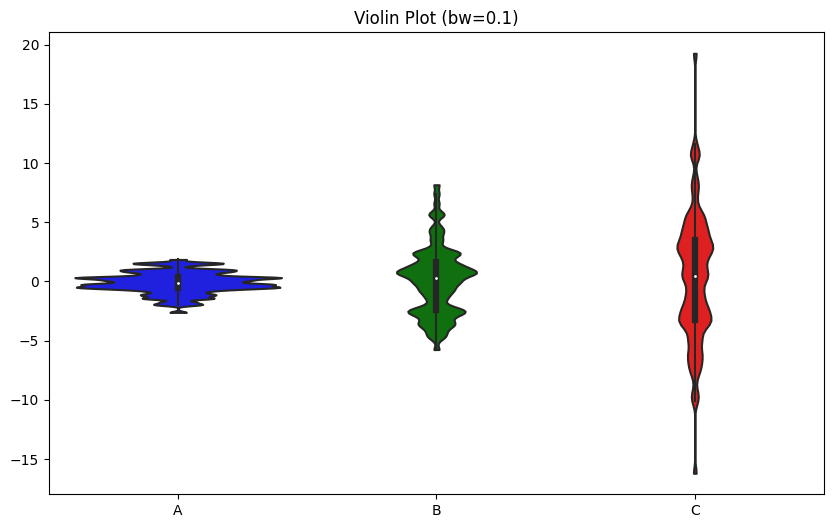

Testing bw=0.2


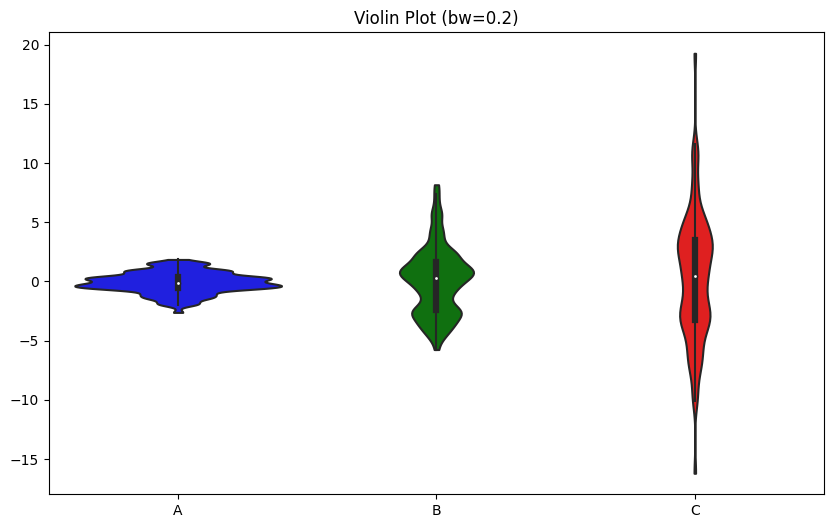

Testing bw=scott


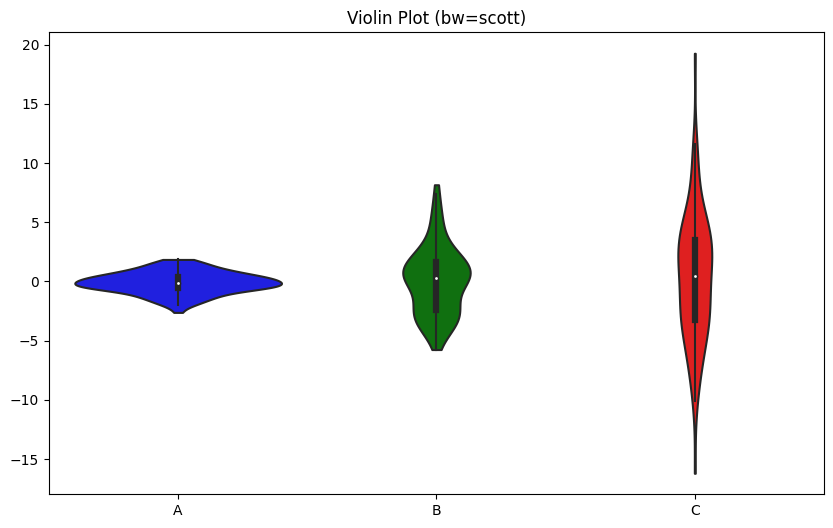

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate sample data
np.random.seed(42)

data = pd.DataFrame({
    'A': np.random.normal(0, 1, 100),
    'B': np.random.normal(0, 3, 100),
    'C': np.random.normal(0, 5, 100)
})
colors = {'A': 'blue', 'B': 'green', 'C': 'red'}

# Function to create violin plot
def plot_violin(bw):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(
        data=data,
        palette=colors,
        cut=0,  # limit to data range
        bw=bw,
    )
    ax.set_title(f'Violin Plot (bw={bw})')
    plt.show()

# Test different combinations
bws = [0.1, 0.2, 'scott']

for bw in bws:
    print(f"Testing bw={bw}")
    plot_violin(bw)